GENERAL CODE TO SOLVE THE SCALAR WAVE FUNCTION

General index:
- PREAMBLE
    - Importing Libraries
    - Some useful functions
    - Importing model and creating nodes and elements
    - Area of elements
- 2. EXAMPLE OF THE STATIC SOLUTION OF THE PROBLEM
    - Load function definition
    - K matrix and F vector definition
    - Reduced Stiffness Matrix and Load Vector with Boundary Conditions
    - Displacement solution
- 3. FIRST TIME DEPENDENT APPROXIMATION
- 4. COMPLETE TIME DEPENDENT PROBLEM
    - 
    - Ploting a graph with the displacements and velocities of the nodes
    - Animation of the resulting movement

# PREAMBLE

##### Importing Libraries

In [1]:
using Gmsh
using Gridap
using GridapGmsh
using LinearAlgebra
using Plots
using DifferentialEquations

##### Some useful functions

In [29]:
# matlab: meshgrid function:
function meshgrid(xin,yin)
    nx=length(xin)
    ny=length(yin)
    xout=zeros(ny,nx)
    yout=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            xout[ix,jx]=xin[jx]
            yout[ix,jx]=yin[ix]
        end
    end
    return (x=xout, y=yout)
end

# Recieves 'nodes' and returns two arrays with the X and Y coordinates of each node.
function get_XY_nodes(nodes)
    N = size(nodes)[1]
    X = zeros(N)
    Y = zeros(N)
    for k in 1:N    
        X[k], Y[k] = nodes[k]
    end
    return X,Y
end

get_XY_nodes (generic function with 1 method)

##### Importing model and creating nodes and elements

Let `N` mean the number of nodes. We define the following structures:

- `nodes` is a N-element vector with the coordinates of the nodes of the mesh.

- `elements` is an array for each element and the nodes that it contains.

In [10]:
model = GmshDiscreteModel("../data/VenturaAccelerometer/test_mesh_v2.msh")
nodes = model.grid.node_coordinates
elements = model.grid.cell_node_ids
N = length(nodes)
display(nodes)
display(elements)

8-element Vector{VectorValue{2, Float64}}:
 VectorValue{2, Float64}(-1.0, 0.5)
  VectorValue{2, Float64}(0.0, 1.0)
 VectorValue{2, Float64}(-1.0, 1.0)
 VectorValue{2, Float64}(-1.0, 0.0)
  VectorValue{2, Float64}(0.0, 0.0)
  VectorValue{2, Float64}(1.0, 0.0)
  VectorValue{2, Float64}(1.0, 0.5)
  VectorValue{2, Float64}(1.0, 1.0)

6-element Gridap.Arrays.Table{Int32, Vector{Int32}, Vector{Int32}}:
 [1, 2, 3]
 [1, 4, 5]
 [5, 6, 7]
 [1, 2, 5]
 [2, 5, 7]
 [2, 7, 8]

Info    : Reading '../data/VenturaAccelerometer/test_mesh_v2.msh'...
Info    : 1 entity
Info    : 8 nodes
Info    : 6 elements
Info    : Done reading '../data/VenturaAccelerometer/test_mesh_v2.msh'


##### Area of elements

In [3]:
Areas = zeros(length(elements))
A = 0
for (i, element) in enumerate(elements)
    area = 0
    for j in 1:length(element)
        k = j % length(element) + 1
        area += nodes[element[j]][1] * nodes[element[k]][2] - nodes[element[j]][2] * nodes[element[k]][1]
    end 
    Areas[i] = abs(area)/2
end

# 2. EXAMPLE OF THE STATIC SOLUTION OF THE PROBLEM

## $$K \textbf{\underline{c}} = \textbf{\underline{F}}(x,y)$$

##### Load function definition

In [11]:
function load(x, y, t)
    x0 = 0.0
    y0 = 0.0
    sigmax = 1
    sigmay = 1
    return exp(-(((x-x0)^2)/(2*sigmax^2) + (y-y0)^2/(2*sigmay^2)))
end

load (generic function with 1 method)

##### K matrix and F vector definition

In [16]:
# Elmenet matrix, gloabl K matrix and F vector:
Ke = zeros(3,3)
K = zeros(N,N)
F = zeros(N)
# Loop for K and F:
for (index,element) in enumerate(elements)
    COORDS = []
    for nd in element
        xi, yi= nodes[nd]
        COORDS = vcat(COORDS, [xi, yi, 1])
    end
    COORDS = transpose(reshape(COORDS, 3, 3))
    ABC = inv(float.(COORDS))

    # K matrix
    for i in 1:3
        for j in 1:3
            Ke[i,j] = ABC[1,i]*ABC[1,j] + ABC[2, i]*ABC[2, j]
        end
    end
    Ke = Ke * Areas[index]

    for (local_i, real_i) in enumerate(element)
        for (local_j, real_j) in enumerate(element)
            K[real_i, real_j]+= Ke[local_i, local_j]
        end
    end

    # F vector
    for (local_i, global_i) in enumerate(element)
        fe = zeros(3)
        for (k,nd) in enumerate(element)
            xi,yi = nodes[nd]
            fe[k] = load(xi, yi, 0)
        end
        F[global_i] += fe[local_i] * Areas[index]/3
    end
end
display("Example of the original K matrix and F vector without reducing the boundary conditions (BC).")
display(K)
display(F)

"Example of the original K matrix and F vector without reducing the boundary conditions (BC). "

8×8 Matrix{Float64}:
  2.5   -0.25  -1.0   -1.0   -0.25   0.0    0.0    0.0
 -0.25   1.75  -0.25   0.0   -0.75   0.0   -0.25  -0.25
 -1.0   -0.25   1.25   0.0    0.0    0.0    0.0    0.0
 -1.0    0.0    0.0    1.25  -0.25   0.0    0.0    0.0
 -0.25  -0.75   0.0   -0.25   1.75  -0.25  -0.25   0.0
  0.0    0.0    0.0    0.0   -0.25   1.25  -1.0    0.0
  0.0   -0.25   0.0    0.0   -0.25  -1.0    2.5   -1.0
  0.0   -0.25   0.0    0.0    0.0    0.0   -1.0    1.25

8-element Vector{Float64}:
 0.17842047617299675
 0.3032653298563167
 0.030656620097620196
 0.050544221642719454
 0.5
 0.050544221642719454
 0.17842047617299675
 0.030656620097620196

##### Reduced Stiffness Matrix and Load Vector with Boundary Conditions

Let:

- ``BC_nodes``:vector with the local numbering of the nodes that have Dirichlet boundary conditions.

- ``BC_values``: vector of the values of the actual boundary conditions.

In [18]:
# Example that clamps the short edges of the plate, global nodes numbers: [1,3,4,6,7,8]

# BC_nodes  = [1,3,4,6,7,8]
# BC_values = [0,0,0,0,0,0]

BC_nodes  = [1]
BC_values = [0]

for i in 1:N
    if i in BC_nodes
        K[i,:] = zeros(N)
        K[i,i] = 1
        index = findfirst.(isequal.(i), (BC_nodes,))
        F[i] = BC_values[Int(index[1])]
    end
end
display(K)
display(F)

8×8 Matrix{Float64}:
  1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
 -0.25   1.75  -0.25   0.0   -0.75   0.0   -0.25  -0.25
 -1.0   -0.25   1.25   0.0    0.0    0.0    0.0    0.0
 -1.0    0.0    0.0    1.25  -0.25   0.0    0.0    0.0
 -0.25  -0.75   0.0   -0.25   1.75  -0.25  -0.25   0.0
  0.0    0.0    0.0    0.0   -0.25   1.25  -1.0    0.0
  0.0   -0.25   0.0    0.0   -0.25  -1.0    2.5   -1.0
  0.0   -0.25   0.0    0.0    0.0    0.0   -1.0    1.25

8-element Vector{Float64}:
 0.0
 0.6065306597126334
 0.06131324019524039
 0.10108844328543891
 1.0
 0.10108844328543891
 0.3568409523459935
 0.06131324019524039

##### Displacement solution

In [20]:
c = K\F

8-element Vector{Float64}:
  0.0
 15.033019377276306
  3.3254327244705113
  3.7540109671980764
 16.14175531056897
 19.036325237312624
 19.102892837643182
 18.607746994585057

# 3. FIRST TIME DEPENDENT APPROXIMATION
## $$K \textbf{\underline{c}} = \textbf{\underline{F}}(x,y,t)$$

This next cell solves the quasi-steady state problem stated above with a loop. It stores the resulting displacements in a matrix `U`. Rows contain the nodes' displacemets, and the columns vary the time instant.

In [19]:
# Time parameters
t0 = 0
dt = 0.1
tf = 1
times = Vector(t0:dt:tf)

U = zeros(N,length(times))

for (t_index,t) in enumerate(times)
    # Defining the F vector for each time step:
    for (e_index,element) in enumerate(elements)
        for (local_i, global_i) in enumerate(element)
            fe = zeros(3)
            for (k,nd) in enumerate(element)
                xi,yi = nodes[nd]
                fe[k] = load(xi, yi, 0)
            end
            F[global_i] += fe[local_i] * Areas[e_index]/3
        end
    end
    # Reducing the F vector for each timestep (K is already reduced):
    for i in 1:N
        if i in BC_nodes
            bc_index = findfirst.(isequal.(i), (BC_nodes,))
            F[i] = BC_values[Int(bc_index[1])]
        end
    end
    c = K\F
    U[:,t_index] = c
end

# 4. COMPLETE TIME DEPENDENT PROBLEM

## $$ M\ddot{\textbf{\underline{c}}} + C \dot{\textbf{\underline{c}}} + K \textbf{\underline{c}} = \textbf{\underline{F}}(x,y,t)$$

##### Creating Mass and Damping Matrices


In [21]:
M = zeros(N,N)
for (index,element) in enumerate(elements)
    Me = I(3)
    Me = Me*Areas[index]/3
    #display(Me)
    for (local_i, real_i) in enumerate(element)
        M[real_i, real_i]+= Me[local_i, local_i]
    end
end

alpha = 0.1
beta  = 0.0
C = alpha * M + beta * K
display(M)
display(C)

8×8 Matrix{Float64}:
 0.333333  0.0  0.0        0.0        0.0  0.0        0.0       0.0
 0.0       0.5  0.0        0.0        0.0  0.0        0.0       0.0
 0.0       0.0  0.0833333  0.0        0.0  0.0        0.0       0.0
 0.0       0.0  0.0        0.0833333  0.0  0.0        0.0       0.0
 0.0       0.0  0.0        0.0        0.5  0.0        0.0       0.0
 0.0       0.0  0.0        0.0        0.0  0.0833333  0.0       0.0
 0.0       0.0  0.0        0.0        0.0  0.0        0.333333  0.0
 0.0       0.0  0.0        0.0        0.0  0.0        0.0       0.0833333

8×8 Matrix{Float64}:
 0.0333333  0.0   0.0         …  0.0         0.0        0.0
 0.0        0.05  0.0            0.0         0.0        0.0
 0.0        0.0   0.00833333     0.0         0.0        0.0
 0.0        0.0   0.0            0.0         0.0        0.0
 0.0        0.0   0.0            0.0         0.0        0.0
 0.0        0.0   0.0         …  0.00833333  0.0        0.0
 0.0        0.0   0.0            0.0         0.0333333  0.0
 0.0        0.0   0.0            0.0         0.0        0.00833333

### Forcing node 5 with a cos(t) Force

In [35]:
function bigF(t)
    # xvec, yvec; were the vectors with the coordinates of the nodes
    bigD = zeros(N)
    for k in 1:N
        # bigD[k] = load(xvec[k],yvec[k],t)
        bigD[k] = 0
    end

    bigD[5] = 2*cos(2*pi/5*t)
    return bigD
end

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function CompleteProblem!(ddu,du,u,p,t)
    # ddu .= (-K*u .-C.*du + F)#.*inv(M)
    ddu .= inv(M) * (bigF(t) - K*u - C*du)
end

#..set initial position and velocity
u0 = fill(0.,N)

v0 = zeros(N)
# v0[4] = 1
                                    
#..set time begin and end forward
t0 = 0.0
tf = 100.0
tspan = (t0,tf)           

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(CompleteProblem!,v0,u0,tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob)

print("Problem solved")


Problem solved

##### Ploting a graph with the displacements and velocities of the nodes

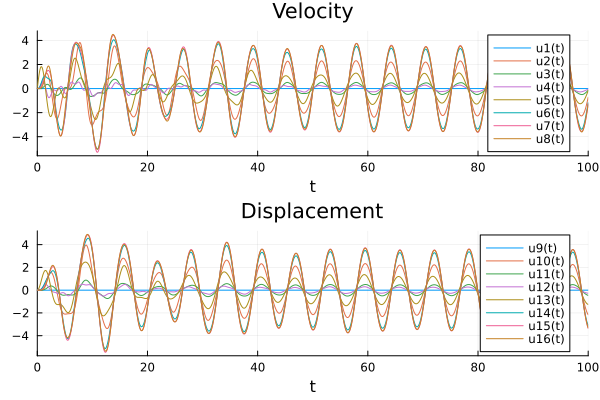

In [26]:
dt = 1
tvec = Vector(t0:dt:tf)

#..velocity and position have vars=(1:N) and vars=(N+1,2N), respectively. 
plot(sol,vars=1)
for i in 2:N-1
    plot!(sol,vars=i)
end
p1 = plot!(sol,vars=N)
title!("Velocity")

plot(sol,vars=N+1)
for i in N+2:2*N-1
    plot!(sol,vars=i)
end
p2 = plot!(sol,vars=2*N)
title!("Displacement")

#..plot solution of velocity and position as function of time  
plot(p1,p2,layout=(2,1))


##### Animation of the resulting movement

In [31]:
xvec, yvec = get_XY_nodes(nodes)

([-1.0, 0.0, -1.0, -1.0, 0.0, 1.0, 1.0, 1.0], [0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.5, 1.0])

┌ Info: Saved animation to c:\Users\ignac\OneDrive - Universidad Politécnica de Madrid\04 - GIA 4 - Cuatri 8\Z - Athens\COURSE\FEM-Athens-group-0\data\anim_fps15.gif
└ @ Plots C:\Users\ignac\.julia\packages\Plots\9Q9pN\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\ignac\\OneDrive - Universidad Politécnica de Madrid\\04 - GIA 4 - Cuatri 8\\Z - Athens\\COURSE\\FEM-Athens-group-0\\data\\anim_fps15.gif")
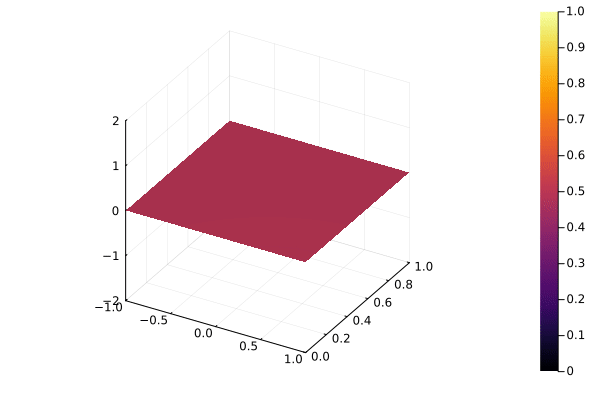

In [36]:

anim = @animate for i in t0:tf
    surface(xvec,yvec,sol(i/10)[N+1:2*N],st=:surface)
    zlims!(-2, 2)
end
gif(anim, "../data/anim_fps15.gif", fps = 15)

### Modeling Impact Force on Center of Plane


In [41]:
function load(x, y, t)
    x0 = 0.0
    y0 = 0.0
    sigmax = 1
    sigmay = 1
    if t<20
        return 1/10*exp(-(((x-x0)^2)/(2*sigmax^2) + (y-y0)^2/(2*sigmay^2)))*(20-t)
    else
        return 0
    end
    # return float(x == 0 && y == 0)
end

function bigF(t)
    # xvec, yvec; were the vectors with the coordinates of the nodes
    bigD = zeros(N)
    for k in 1:N
        bigD[k] = load(xvec[k],yvec[k],t)
    end

    bigD[2] = 0
    return bigD
end

#println(bigF(1))

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function CompleteProblem!(ddu,du,u,p,t)
    # ddu .= (-K*u .-C.*du + F)#.*inv(M)
    ddu .= inv(M) * (bigF(t) - K*u - C*du)
end

#..set initial position and velocity
u0 = fill(0.,N)
# u0[8] = .2

v0 = zeros(N)
v0[4] = 1
                                    
#..set time begin and end forward
tspan = (0.0,100.0)           

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(CompleteProblem!,v0,u0,tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob)

print("Done")


Done

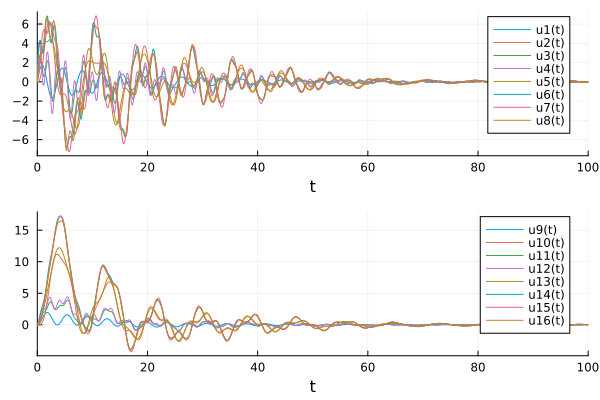

In [42]:
#..plot the source term
tvec = Vector(0.:0.01:10.)
#fvec = f.(tvec)
# p1 = plot(tvec,fvec,label="Excitation")


#..velocity and position have vars=(1,2) and vars=(3,4), respectively. 
plot(sol,vars=1)
for i in 2:N-1
    plot!(sol,vars=i)
end
p1 = plot!(sol,vars=N)

plot(sol,vars=N+1)
for i in N+2:2*N-1
    plot!(sol,vars=i)
end
p2 = plot!(sol,vars=2*N)


#..plot solution of velocity and position as function of time  
plot(p1,p2,layout=(2,1))

┌ Info: Saved animation to c:\Users\ignac\OneDrive - Universidad Politécnica de Madrid\04 - GIA 4 - Cuatri 8\Z - Athens\COURSE\FEM-Athens-group-0\data\anim_fps15.gif
└ @ Plots C:\Users\ignac\.julia\packages\Plots\9Q9pN\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\ignac\\OneDrive - Universidad Politécnica de Madrid\\04 - GIA 4 - Cuatri 8\\Z - Athens\\COURSE\\FEM-Athens-group-0\\data\\anim_fps15.gif")
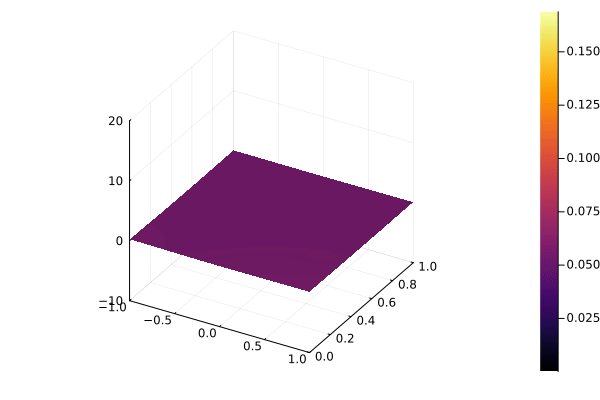

In [43]:
anim = @animate for i ∈ 1:100
    surface(xvec,yvec,sol(i/10)[N+1:2*N],st=:surface)
    zlims!(-10, 20)
end
gif(anim, "../data/anim_fps15.gif", fps = 15)